В вашем распоряжении следующие данные: технические характеристики, комплектации и цены автомобилей. 
Нужно построить модель для определения стоимости. 

Важные параметры:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Видны явные аномалии в RegistrationYear (9999, 1000) и Power (20000).  
Выясним, каково количество объектов с такими значениями.

Очевидно, что дата не может быть старше 2020 г.

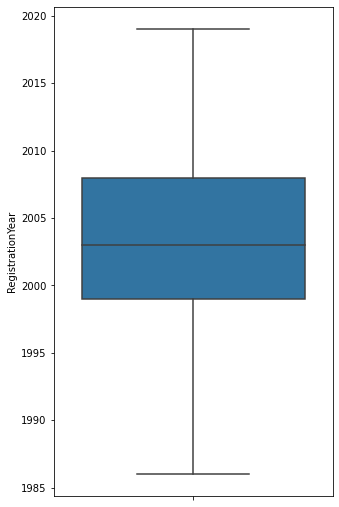

In [6]:
plt.figure(figsize=(5, 9))
sns.boxplot(x = 'RegistrationYear', data = data, orient='v', showfliers=False)
plt.show()

Steps to perform Outlier Detection by identifying the lowerbound and upperbound of the data:
1. Arrange your data in ascending order
2. Calculate Q1 ( the first Quarter)
3. Calculate Q3 ( the third Quartile)
4. Find IQR = (Q3 - Q1)
5. Find the lower Range = Q1 -(1.5 * IQR)
6. Find the upper Range = Q3 + (1.5 * IQR)

Определим нижнюю границу, до которой будем брать значения года.

In [7]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn, [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range

In [8]:
outlier_treatment(data['RegistrationYear'])

(1985.5, 2021.5)

Построим распределение авто по дате производства.

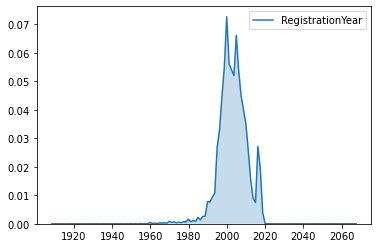

In [9]:
sns.kdeplot(data['RegistrationYear'], shade=True, clip=(1800, 2100)) # выбрали определенные значения по оси x
plt.show()

Построим распределение авто по мощности

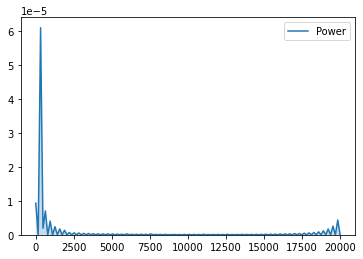

In [10]:
sns.kdeplot(data['Power'], shade=True) 
plt.show()

Основное количество значений мощностей лежит до 2500.

In [11]:
len(data[data['Power'] <= 2500])

354270

Создадим очищенный датасет без аномальных значений по параметрам RegistrationYear и Power

In [12]:
data_clean = data[(data['RegistrationYear'] < 2020) & 
                  (data['RegistrationYear'] > 1960) & 
                  (data['Power'] <= 2500)]

In [13]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353557 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        353557 non-null  object
 1   Price              353557 non-null  int64 
 2   VehicleType        316445 non-null  object
 3   RegistrationYear   353557 non-null  int64 
 4   Gearbox            334111 non-null  object
 5   Power              353557 non-null  int64 
 6   Model              334187 non-null  object
 7   Kilometer          353557 non-null  int64 
 8   RegistrationMonth  353557 non-null  int64 
 9   FuelType           321032 non-null  object
 10  Brand              353557 non-null  object
 11  NotRepaired        282897 non-null  object
 12  DateCreated        353557 non-null  object
 13  NumberOfPictures   353557 non-null  int64 
 14  PostalCode         353557 non-null  int64 
 15  LastSeen           353557 non-null  object
dtypes: int64(7), object(

Обработаем пропущенные данные

In [14]:
data_clean.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,353557.000000,353557.000000,353557.000000,353557.000000,353557.000000,353557.0,353557.000000
mean,4416.826082,2003.173155,107.569094,128363.658477,5.721196,0.0,50518.320845
std,4511.410788,7.159181,72.968780,37704.000585,3.724266,0.0,25779.478365
min,0.000000,1961.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1080.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,2019.000000,2461.000000,150000.000000,12.000000,0.0,99998.000000


In [15]:
data_clean.isnull().sum() * 100 / len(data_clean)

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.496752
RegistrationYear      0.000000
Gearbox               5.500103
Power                 0.000000
Model                 5.478607
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.199365
Brand                 0.000000
NotRepaired          19.985462
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

В категориальных признаках присутствуют пропуски. Причем, в некоторых столбцах в достаточном количестве.

Выясним, присутствуют ли дубликаты.

In [16]:
data_clean.duplicated().sum()

4

In [17]:
data_clean = data_clean.drop_duplicates() # удалим дубликаты

In [18]:
data_clean.duplicated().sum()

0

Дубликатов нет.

Удалим из датасета data_clean столбцы, которые не будут оказывать влияние на обучение модели

In [19]:
data_clean = data_clean.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [20]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353553 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              353553 non-null  int64 
 1   VehicleType        316441 non-null  object
 2   RegistrationYear   353553 non-null  int64 
 3   Gearbox            334107 non-null  object
 4   Power              353553 non-null  int64 
 5   Model              334183 non-null  object
 6   Kilometer          353553 non-null  int64 
 7   RegistrationMonth  353553 non-null  int64 
 8   FuelType           321028 non-null  object
 9   Brand              353553 non-null  object
 10  NotRepaired        282893 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Пропуски присутствуют в таких местах, где мы не можем однозначно или даже примерно определить их значение. Заполним их значением "unknown".

In [21]:
data_clean = data_clean.fillna('unknown')

In [22]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353553 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              353553 non-null  int64 
 1   VehicleType        353553 non-null  object
 2   RegistrationYear   353553 non-null  int64 
 3   Gearbox            353553 non-null  object
 4   Power              353553 non-null  int64 
 5   Model              353553 non-null  object
 6   Kilometer          353553 non-null  int64 
 7   RegistrationMonth  353553 non-null  int64 
 8   FuelType           353553 non-null  object
 9   Brand              353553 non-null  object
 10  NotRepaired        353553 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Избавились от пропусков, дубликатов и аномальных значений.

# 2. Обучение моделей

Разобьем выборки на обучающую и тестовую

Выделим признаки и целевой признак.

In [23]:
features = data_clean.drop(['Price'], axis=1)
target = data_clean['Price']
categorical = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 
                'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']
features[categorical] = features[categorical].astype('category')

In [24]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353553 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        353553 non-null  category
 1   RegistrationYear   353553 non-null  category
 2   Gearbox            353553 non-null  category
 3   Power              353553 non-null  int64   
 4   Model              353553 non-null  category
 5   Kilometer          353553 non-null  int64   
 6   RegistrationMonth  353553 non-null  category
 7   FuelType           353553 non-null  category
 8   Brand              353553 non-null  category
 9   NotRepaired        353553 non-null  category
dtypes: category(8), int64(2)
memory usage: 11.1 MB


Разобьем данные на обучающую и тестовую выборки.

In [25]:
features_train, features_test, target_train, target_test = \
                                                    train_test_split(features, target, test_size=0.3, random_state=128)

Подберем оптимальные гиперпараметры с помощью GridSearchCV

In [26]:
# Подбор параметров для модели LightGBM
score_func = make_scorer(mean_squared_error, greater_is_better=False)

model_lgbm = lgb.LGBMRegressor( 
    boosting_type="gbdt",
    objective='regression',
    random_state=128, 
    n_estimators=50,
    num_leaves=30, 
    max_depth=8,
    learning_rate=0.5,    
)

params_opt = {'n_estimators': [100, 150, 200], 
              'num_leaves': [20, 40, 60],
              'max_depth': [10, 20, 30]
             }

gridSearchCV = GridSearchCV(estimator=model_lgbm, 
                            param_grid=params_opt, 
                            scoring=score_func)

gridSearchCV.fit(features_train, target_train)

GridSearchCV(estimator=LGBMRegressor(learning_rate=0.5, max_depth=8,
                                     n_estimators=50, num_leaves=30,
                                     objective='regression', random_state=128),
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 150, 200],
                         'num_leaves': [20, 40, 60]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [27]:
gridSearchCV.best_params_

{'max_depth': 20, 'n_estimators': 200, 'num_leaves': 40}

Обучим модель с этими параметрами

In [28]:
%%time
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 20, 
    'learning_rate': 0.5,
    'num_leaves': 40,
    'verbose': 0 
    }

n_estimators = 200

d_train = lgb.Dataset(features_train, label=target_train)
d_test = lgb.Dataset(features_test, label=target_test)
watchlist = [d_test]

model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=10)  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[10]	valid_0's rmse: 1863.07
[20]	valid_0's rmse: 1807.66
[30]	valid_0's rmse: 1788.77
[40]	valid_0's rmse: 1773.88
[50]	valid_0's rmse: 1767.21
[60]	valid_0's rmse: 1764.98
[70]	valid_0's rmse: 1757.76
[80]	valid_0's rmse: 1755.15
[90]	valid_0's rmse: 1751.28
[100]	valid_0's rmse: 1748.94
[110]	valid_0's rmse: 1747.91
[120]	valid_0's rmse: 1747.75
[130]	valid_0's rmse: 1747.9
[140]	valid_0's rmse: 1747.97
[150]	valid_0's rmse: 1747.13
[160]	valid_0's rmse: 1748.75
[170]	valid_0's rmse: 1749.16
[180]	valid_0's rmse: 1749.98
[190]	valid_0's rmse: 1750.49
[200]	valid_0's rmse: 1751.34
Wall time: 5.56 s


In [29]:
%%time
predictions = model.predict(features_test)

error = mean_squared_error(target_test, predictions, squared=False)
print(error)

1751.3429733268522
Wall time: 1.41 s


Обучим модель CatBoost

In [30]:
features = data_clean.drop(['Price', 'FuelType', 'Gearbox'], axis=1)
target = data_clean['Price']

categorical = ['RegistrationMonth', 'RegistrationYear', 'VehicleType', 'NotRepaired', 'Model', 'Brand']
# если добавить в этот список FuelType и Gearbox, то Jupiter зависает и вылетает, даже не выдавая ошибки.

In [31]:
features_train, features_test, target_train, target_test = \
                                                    train_test_split(features, target, test_size=0.3, random_state=128)

In [32]:
for col in categorical:
    features_train[col] = features_train[col].astype(str)
    features_test[col] = features_test[col].astype(str)    

In [33]:
# %%time
# model = CatBoostRegressor(loss_function='RMSE', iterations=200, depth=8, learning_rate=0.5)

# # model.fit(features_train, target_train, cat_features=categorical, verbose=1)
# model.fit(features_train, target_train, cat_features=categorical, verbose=1)

# predictions = model.predict(features_test)

# rmse = mean_squared_error(target_test, predictions, squared=False)

# print(rmse)  

In [34]:
cv_dataset = Pool(data=features_train,
                  label=target_train,
                  cat_features=categorical)

 
model_catboost = CatBoostRegressor()
 
grid = {'learning_rate': [0.5],
        'depth': [6, 9, 12],
        'iterations': [100]}


 
grid_search_result = model_catboost.grid_search(grid, 
                                       X=cv_dataset,
                                       cv=3,
                                       plot=False)



bestTest = 1858.865727
bestIteration = 98

0:	loss: 1858.8657266	best: 1858.8657266 (0)	total: 26.1s	remaining: 52.1s

bestTest = 1814.41717
bestIteration = 99

1:	loss: 1814.4171702	best: 1814.4171702 (1)	total: 1m 4s	remaining: 32.2s

bestTest = 1804.092264
bestIteration = 99

2:	loss: 1804.0922642	best: 1804.0922642 (2)	total: 2m 13s	remaining: 0us
Estimating final quality...


После GridSearchCV для CatBoost модель уже обучена. осталось прменить ее на тестовой выборке.

In [35]:
%%time
predictions = model_catboost.predict(features_test)

rmse = mean_squared_error(target_test, predictions, squared=False)

print(rmse)  

1783.81612853662
Wall time: 1.16 s


# 3. Анализ моделей

В проведенном исследовании были обучены две модели: LightGBM и CatBoost. Оптимальные параметры подбирались с использованием GridSearchCV. Посчитаны значения RMSE для обоих моделей и время вычисления этого параметра. LightGBM показала значение RMSE=1751, время работы - 1.9 с. CatBoost: RMSE = 1783, время работы - 1.18 с.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей